In [74]:
import os
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('./dataset/2/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./dataset/2/lettuce_dataset.csv
./dataset/2/lettuce_dataset_updated.csv
./dataset/2/unseen_data.csv


In [75]:


def windowed_dataset(series, batch_size, n_past=24, n_future=4, shift=1):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=n_past+n_future, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(n_past+n_future))
    ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-n_future], w[-n_future:, :1]))
    ds = ds.batch(batch_size).prefetch(shift)
    return ds

In [76]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
# Retrieve dataset
df = pd.read_csv('./dataset/2/lettuce_dataset.csv', sep=',', encoding='ISO-8859-1')

df.head()

,Plant_ID,Date,Temperature (°C),Humidity (%),TDS Value (ppm),pH Level,Growth Days
0,1,8/3/2023,33.4,53,582,6.4,1
1,1,8/4/2023,33.5,53,451,6.1,2
2,1,8/5/2023,33.4,59,678,6.4,3
3,1,8/6/2023,33.4,68,420,6.4,4
4,1,8/7/2023,33.4,74,637,6.5,5


In [77]:
# Convert 'Date' to numerical values if necessary
df['Date'] = pd.to_datetime(df['Date']).map(pd.Timestamp.toordinal)

# Normalize the input features
target = 'Growth Days'
features = ['Date', 'Temperature (°C)', 'TDS Value (ppm)', 'pH Level']

delete = df.drop(columns=['Plant_ID'],axis=1)

X = df[features]
y = df[target]

print(df.head())

   Plant_ID    Date  Temperature (°C)  Humidity (%)  TDS Value (ppm)  \
0         1  738735              33.4            53              582   
1         1  738736              33.5            53              451   
2         1  738737              33.4            59              678   
3         1  738738              33.4            68              420   
4         1  738739              33.4            74              637   

   pH Level  Growth Days  
0       6.4            1  
1       6.1            2  
2       6.4            3  
3       6.4            4  
4       6.5            5  


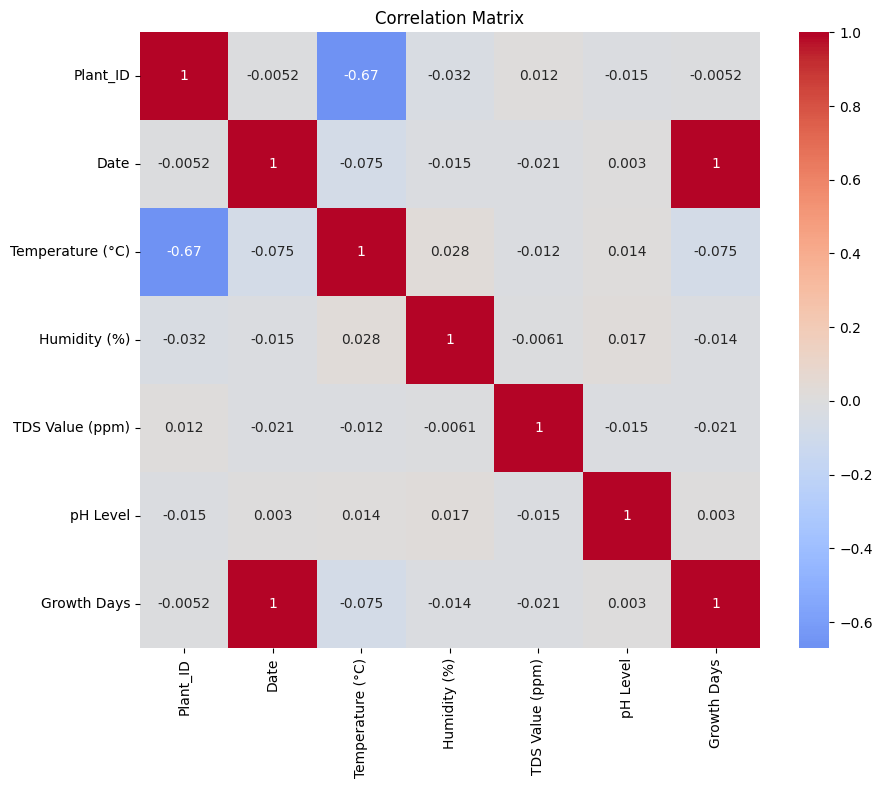

In [78]:



scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# y = df['Growth Days']
# # Delete column date, plant_id
# df = 

# # Number of features in dataset
# N_FEATURES = df.shape[1]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create correlation matrix
correlation_matrix = df.corr()


# Visualize the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

# print(F'X_train : {X_train}')
# print(F'X_test : {X_test}')
# print(F'y_train : {y_train}')
# print(F'y_test : {y_test}')



In [79]:


X = data[features]
y = data[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, monitor='mae', monitor1='val_mae', target=0.1):
        super(CustomCallback, self).__init__()
        self.monitor = monitor
        self.monitor1 = monitor1
        self.target = target
        
    def on_epoch_end(self, epoch, logs=None):
        if logs[self.monitor] is not None and logs[self.monitor1] is not None:
            if logs[self.monitor] < self.target and logs[self.monitor1] < self.target:
                print(f'\n{self.monitor}: {logs[self.monitor]} < {self.target}')
                print(f'\n{self.monitor1}: {logs[self.monitor1]} < {self.target}')
                self.model.stop_training = True

# Build the model
model = Sequential([
    Dense(64, input_shape=(X_train.shape[1],)),
    Dense(32),
    Dense(1, activation='linear')  # Linear activation for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

cust_callbacks = CustomCallback(monitor='mae', target=0.045)
# Train the model
history = model.fit(X_train, y_train, epochs=1000, validation_split=0.2, batch_size=32, callbacks=[cust_callbacks])



Epoch 1/1000
64/64 [==============================] - 1s 4ms/step - loss: 607.4794 - mae: 22.3202 - val_loss: 445.9912 - val_mae: 20.0766
Epoch 2/1000
64/64 [==============================] - 0s 2ms/step - loss: 277.3707 - mae: 15.9800 - val_loss: 111.1829 - val_mae: 9.9477
Epoch 3/1000
64/64 [==============================] - 0s 2ms/step - loss: 33.3424 - mae: 4.5277 - val_loss: 0.6749 - val_mae: 0.6913
Epoch 4/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0648 - mae: 0.1377 - val_loss: 0.0050 - val_mae: 0.0308
Epoch 5/1000
49/64 [=====================>........] - ETA: 0s - loss: 7.7670e-04 - mae: 0.0081
mae: 0.006816389039158821 < 0.045

val_mae: 0.004675260279327631 < 0.045
64/64 [==============================] - 0s 2ms/step - loss: 6.0248e-04 - mae: 0.0068 - val_loss: 0.0039 - val_mae: 0.0047


In [80]:
print("The model Result ")

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f'Mean Absolute Error on test data: {mae}')

# Make predictions
y_pred = model.predict(X_test)

# Optional: Convert predictions and actual values to a more readable format
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})
print(results.head())

The model Result 
20/20 [==============================] - 0s 895us/step - loss: 7.1280e-07 - mae: 6.9072e-04
Mean Absolute Error on test data: 0.0006907215574756265
20/20 [==============================] - 0s 842us/step
      Actual  Predicted
254       25  24.999664
3162      40  40.000336
969       14  13.999002
940       30  30.000425
331       10  10.000191
